In [8]:
# !unzip activities.zip

In [82]:
# !pip install mlxtend
# !pip install catboost

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense,
    Dropout,
)
from sklearn.neural_network import MLPClassifier

from catboost import CatBoostClassifier


%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.base import clone

In [3]:
df = pd.read_csv('activities.txt', sep='\t')

In [4]:
print(df.shape)
df.head()

(82552, 23)


,Y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21
0,1,100,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,32.1875,...,0.000275,-0.013352,-0.039315,30.75,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328
1,1,100,30.375,2.24615,7.48180,5.55219,-0.431227,0.002685,-0.062964,32.1875,...,-0.029411,-0.037321,-0.033805,30.75,9.73536,-2.03681,0.019118,0.005819,-0.017912,0.015243
2,1,100,30.375,2.30000,7.10681,6.09309,0.075692,-0.030792,0.005246,32.1875,...,-0.009560,-0.055878,-0.044714,30.75,9.73745,-1.84729,0.056553,0.015376,-0.011798,0.011387
3,1,100,30.375,2.49455,7.52335,6.17157,-0.259058,-0.267895,-0.038533,32.1875,...,-0.067753,0.020297,-0.012148,30.75,9.58444,-1.84538,-0.060796,-0.012672,-0.009233,0.005823
4,1,101,30.375,2.71654,8.30596,4.78671,0.377115,-0.023688,-0.020670,32.1875,...,0.007856,0.001881,-0.058687,30.75,9.69963,-1.92299,0.056635,0.050959,-0.042562,-0.009289


## (0) data analysis + preparation

<AxesSubplot:>

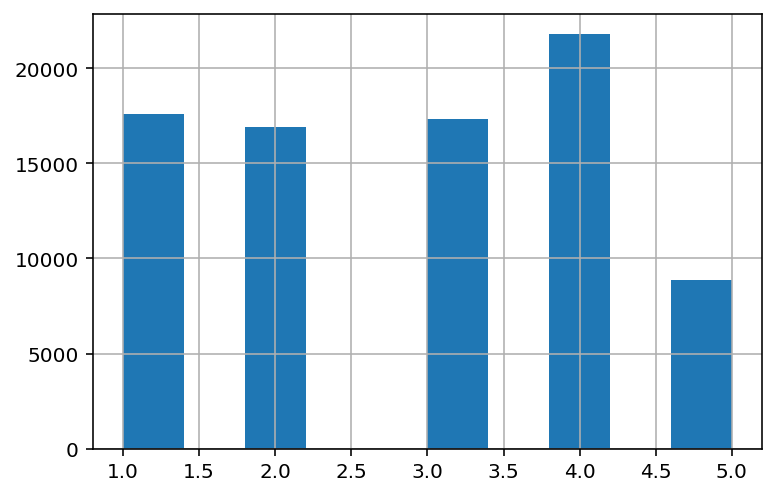

In [5]:
df.Y.hist()

In [6]:
df.isna().sum()

Y        0
X0       0
X1     740
X2     740
X3     740
X4     740
X5     740
X6     740
X7     740
X8     122
X9     122
X10    122
X11    122
X12    122
X13    122
X14    122
X15    336
X16    336
X17    336
X18    336
X19    336
X20    336
X21    336
dtype: int64

In [7]:
# impulsional step, could be replaced with something reasonable
df = df.dropna()
df.isna().sum()

Y      0
X0     0
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
dtype: int64

In [8]:
df.dtypes

Y        int64
X0       int64
X1     float64
X2     float64
X3     float64
X4     float64
X5     float64
X6     float64
X7     float64
X8     float64
X9     float64
X10    float64
X11    float64
X12    float64
X13    float64
X14    float64
X15    float64
X16    float64
X17    float64
X18    float64
X19    float64
X20    float64
X21    float64
dtype: object

## (1) reading + spliting data

In [9]:
y = df.Y.to_numpy()
X = df.drop('Y', axis=1).to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, stratify=y, random_state=322)

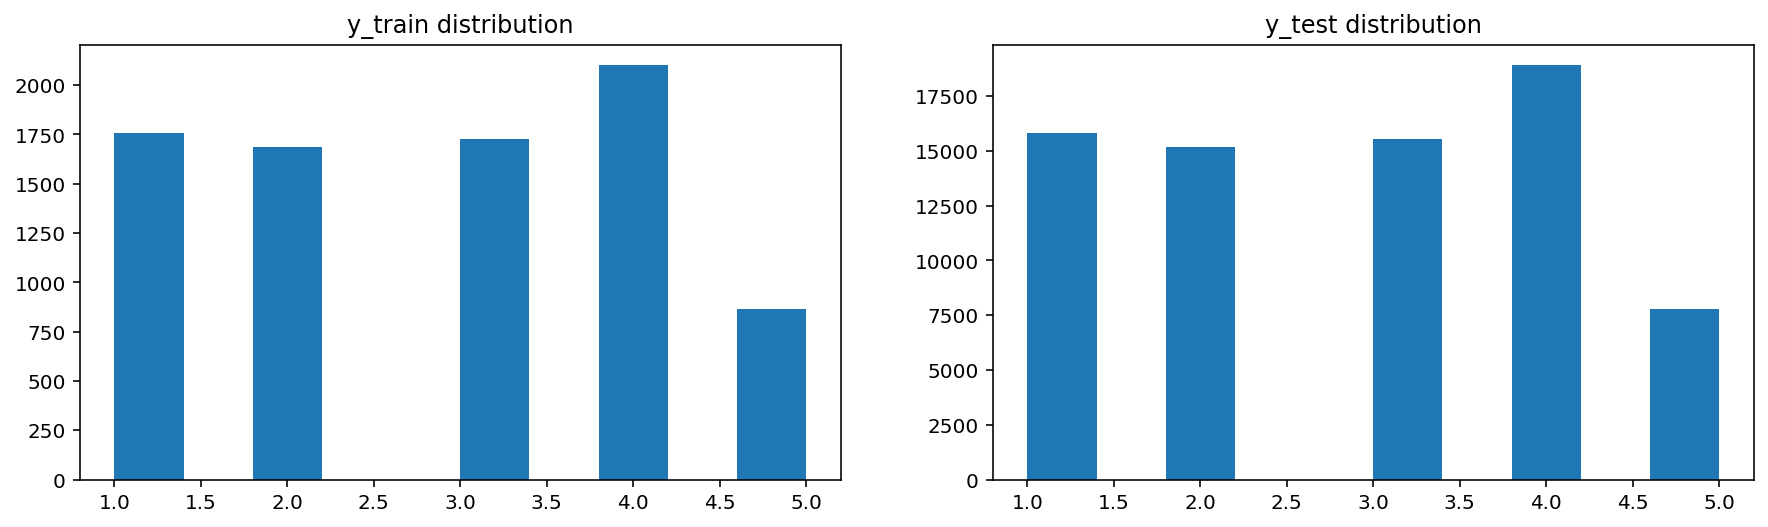

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(y_train)
ax[1].hist(y_test)
ax[0].set_title('y_train distribution')
ax[1].set_title('y_test distribution');

## (2) normalizing features

In [12]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train, X_test = sc.transform(X_train), sc.transform(X_test)
print(X_train)
print(X_test)

[[0.44604317 0.8034188  0.81440476 ... 0.64633001 0.70076997 0.91624988]
 [0.84172662 0.00854701 0.66672777 ... 0.72315817 0.57340631 0.28742372]
 [0.88489209 0.4017094  0.92888402 ... 0.39566267 0.20564237 0.05144938]
 ...
 [0.17985612 0.43589744 0.87687446 ... 0.53432702 0.51390505 0.4899987 ]
 [0.4676259  0.68376068 0.68225737 ... 0.64263407 0.53622485 0.50021333]
 [0.32374101 0.68376068 0.70330586 ... 0.35105718 0.59932413 0.37421999]]
[[0.23741007 0.99145299 0.72427555 ... 0.53209197 0.5291409  0.49096794]
 [0.23021583 0.42735043 0.81140328 ... 0.53898199 0.518731   0.48806151]
 [0.23021583 0.86324786 0.78644246 ... 0.54072541 0.52155189 0.48885668]
 ...
 [0.34532374 0.65811966 0.72389351 ... 0.53707104 0.51697441 0.48891091]
 [0.29496403 0.74358974 0.71796469 ... 0.53912153 0.52434534 0.48890793]
 [0.44604317 0.24786325 0.6508764  ... 0.51396575 0.50538209 0.45368177]]


## (3) multinomial logit 

In [13]:
sgd_logit = SGDClassifier(penalty = 'l2', 
                          loss = 'log',
                          eta0 = 0.001,
                          learning_rate = 'adaptive', 
                          class_weight = 'balanced',
                          random_state = 0,
                          n_jobs = -1)

sgd_logit.fit(X_train, y_train)

SGDClassifier(class_weight='balanced', eta0=0.001, learning_rate='adaptive',
              loss='log', n_jobs=-1, random_state=0)

In [14]:
train_pred = sgd_logit.predict(X_train)
test_pred = sgd_logit.predict(X_test)
print(f'train accuracy: {accuracy_score(y_train, train_pred):.3f}\n'
      f'test accuracy: {accuracy_score(y_test, test_pred):.3f}')

train accuracy: 0.853
test accuracy: 0.851


In [15]:
print(f'Train:\n{classification_report(y_train, train_pred)}\n\n'
      f'Test:\n{classification_report(y_test, test_pred)}')

Train:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93      1757
           2       0.68      0.72      0.70      1688
           3       0.76      0.69      0.72      1726
           4       0.95      1.00      0.98      2100
           5       0.98      0.91      0.94       866

    accuracy                           0.85      8137
   macro avg       0.86      0.85      0.85      8137
weighted avg       0.85      0.85      0.85      8137


Test:
              precision    recall  f1-score   support

           1       0.92      0.93      0.92     15818
           2       0.68      0.72      0.70     15193
           3       0.76      0.68      0.72     15530
           4       0.95      1.00      0.98     18898
           5       0.98      0.92      0.95      7799

    accuracy                           0.85     73238
   macro avg       0.86      0.85      0.85     73238
weighted avg       0.85      0.85      0.85     73238



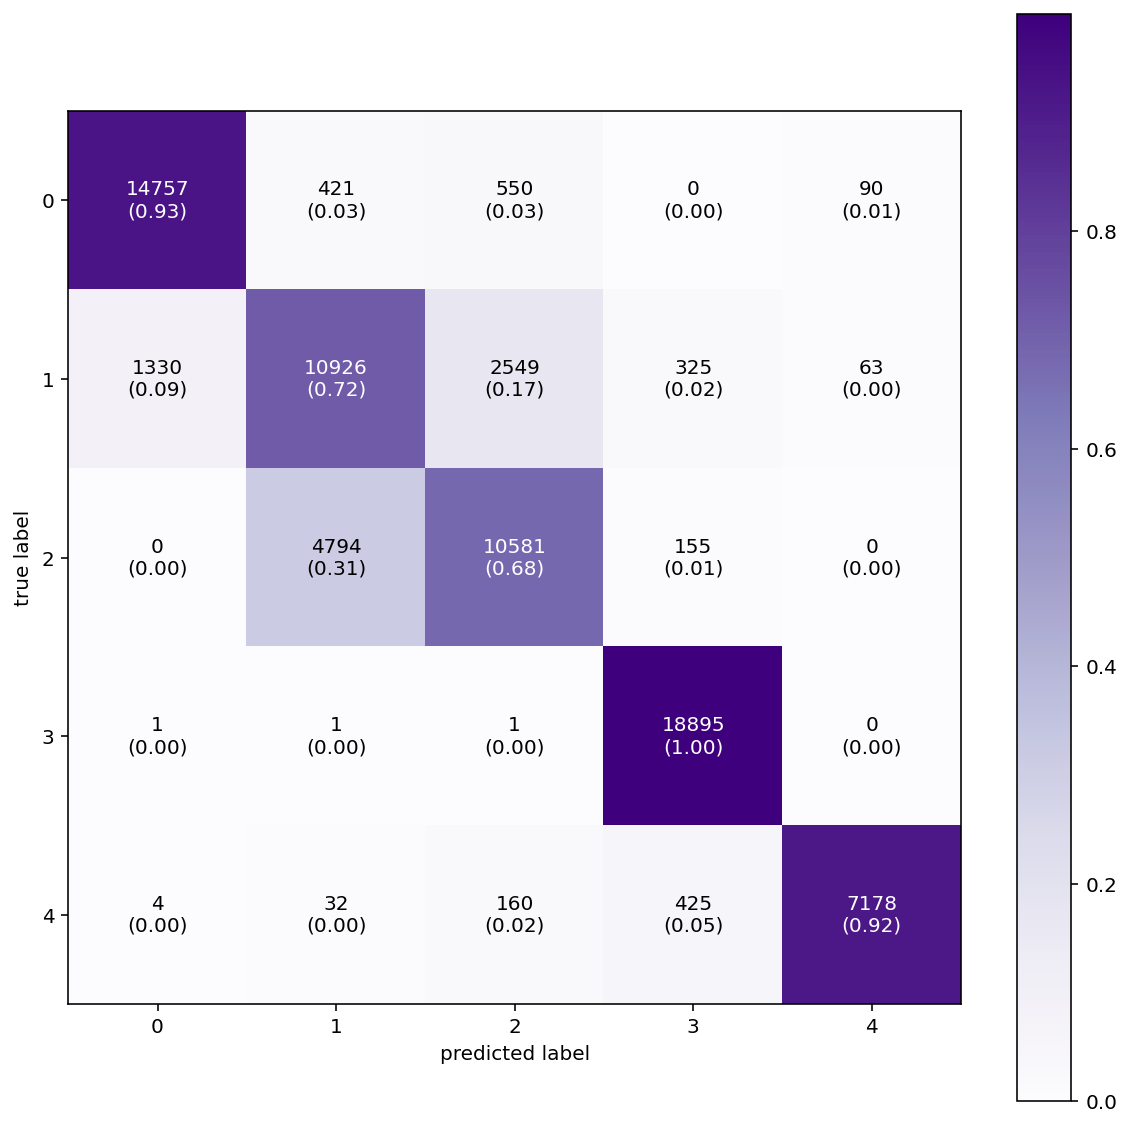

In [16]:
cm_sgd = confusion_matrix(y_target=y_test, y_predicted=test_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm_sgd,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='Purples',
                                figsize=(10, 10))

plt.show()

### most important feature

In [20]:
mask_train = (y_train == 5) | (y_train == 4)
mask_test = (y_test == 5) | (y_test == 4)
y_train45 = y_train[mask_train]
X_train45 = X_train[mask_train]
y_test45 = y_test[mask_test]
X_test45 = X_test[mask_test]

In [21]:
sfs1 = SFS(sgd_logit, 
           k_features=5, 
           forward=True, 
           floating=False, 
           verbose=2,
           n_jobs=-1, 
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train45, y_train45)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.9s finished

[2022-04-29 19:47:36] Features: 1/5 -- score: -0.05799055967633176[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.1s finished

[2022-04-29 19:47:36] Features: 2/5 -- score: -0.026298044504383007[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished

[2022-04-29 19:47:36] Features: 3/5 -- score: -0.022926500337154418[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.0s finished

[2022-04-29 19:47:36] Features: 4/5 -- score: 

In [22]:
features = [x for i, x in enumerate(list(df.drop('Y', axis=1).columns)) if i in sfs1.k_feature_idx_]
print(features)

['X0', 'X1', 'X3', 'X8', 'X15']


In [23]:
features = df.drop('Y', axis=1).columns
print(*features)

for i in range(0, sgd_logit.coef_.shape[0]):
    top5_indices = np.argsort(sgd_logit.coef_[i])[-1]
    print(f'class {i+1}, most important feature: {features[top5_indices]}')

X0 X1 X2 X3 X4 X5 X6 X7 X8 X9 X10 X11 X12 X13 X14 X15 X16 X17 X18 X19 X20 X21
class 1, most important feature: X11
class 2, most important feature: X10
class 3, most important feature: X1
class 4, most important feature: X8
class 5, most important feature: X0


In [61]:
sfs1 = SFS(sgd_logit, 
           k_features=22, 
           forward=True, 
           floating=False, 
           verbose=2,
           n_jobs=-1, 
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.7s finished

[2022-04-29 21:17:25] Features: 1/22 -- score: -0.9064765884232519[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.0s finished

[2022-04-29 21:17:26] Features: 2/22 -- score: -0.4045717094752366[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.1s finished

[2022-04-29 21:17:27] Features: 3/22 -- score: -0.3289910286346319[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.1s finished

[2022-04-29 21:17:28] Features: 4/22 -- score: -

In [62]:
sfs1.subsets_

{1: {'feature_idx': (0,),
  'cv_scores': array([-0.90647659]),
  'avg_score': -0.9064765884232519,
  'feature_names': ('0',)},
 2: {'feature_idx': (0, 10),
  'cv_scores': array([-0.40457171]),
  'avg_score': -0.4045717094752366,
  'feature_names': ('0', '10')},
 3: {'feature_idx': (0, 2, 10),
  'cv_scores': array([-0.32899103]),
  'avg_score': -0.3289910286346319,
  'feature_names': ('0', '2', '10')},
 4: {'feature_idx': (0, 2, 10, 17),
  'cv_scores': array([-0.31448937]),
  'avg_score': -0.3144893695465159,
  'feature_names': ('0', '2', '10', '17')},
 5: {'feature_idx': (0, 2, 4, 10, 17),
  'cv_scores': array([-0.30355168]),
  'avg_score': -0.3035516775224284,
  'feature_names': ('0', '2', '4', '10', '17')},
 6: {'feature_idx': (0, 2, 4, 10, 16, 17),
  'cv_scores': array([-0.29040187]),
  'avg_score': -0.2904018680103232,
  'feature_names': ('0', '2', '4', '10', '16', '17')},
 7: {'feature_idx': (0, 2, 4, 10, 16, 17, 18),
  'cv_scores': array([-0.28573184]),
  'avg_score': -0.28573184

In [63]:
subsamples = [np.array(val['feature_names']).astype(int) for val in sfs1.subsets_.values()]
subsamples

[array([0]),
 array([ 0, 10]),
 array([ 0,  2, 10]),
 array([ 0,  2, 10, 17]),
 array([ 0,  2,  4, 10, 17]),
 array([ 0,  2,  4, 10, 16, 17]),
 array([ 0,  2,  4, 10, 16, 17, 18]),
 array([ 0,  2,  3,  4, 10, 16, 17, 18]),
 array([ 0,  2,  3,  4, 10, 14, 16, 17, 18]),
 array([ 0,  2,  3,  4,  9, 10, 14, 16, 17, 18]),
 array([ 0,  2,  3,  4,  7,  9, 10, 14, 16, 17, 18]),
 array([ 0,  2,  3,  4,  5,  7,  9, 10, 14, 16, 17, 18]),
 array([ 0,  2,  3,  4,  5,  7,  9, 10, 13, 14, 16, 17, 18]),
 array([ 0,  2,  3,  4,  5,  7,  9, 10, 13, 14, 16, 17, 18, 19]),
 array([ 0,  2,  3,  4,  5,  7,  9, 10, 12, 13, 14, 16, 17, 18, 19]),
 array([ 0,  2,  3,  4,  5,  7,  9, 10, 12, 13, 14, 16, 17, 18, 19, 20]),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 16, 17, 18, 19, 20]),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 16, 17, 18, 19, 20,
        21]),
 array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19,
        20, 21]),
 array([ 0,  2,  3,  4,  5,  6,  7,

In [64]:
def custom_features_model(model, features):
    newmodel = clone(model)
    newmodel.fit(X_train, y_train)
    save_coefs = newmodel.coef_[:, features]
    coef_new = np.zeros(model.coef_.shape)
    coef_new[:, features] = save_coefs
    newmodel.coef_ = coef_new
    return newmodel

In [65]:
def subsamples_cm(subsamples, model, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(len(subsamples), 1, figsize=(6, len(subsamples) * 6))
    
    for i, sample in enumerate(subsamples):
        sgd2feats = custom_features_model(sgd_logit, sample)
        y_pred = sgd2feats.predict(X_test)
        cm = confusion_matrix(y_target=y_test, y_predicted=y_pred)
        plot_confusion_matrix(conf_mat=cm,
                                        show_absolute=True,
                                        show_normed=True,
                                        cmap='Purples',
                                        axis=ax[i])
        ax[i].set_title(str(sample));

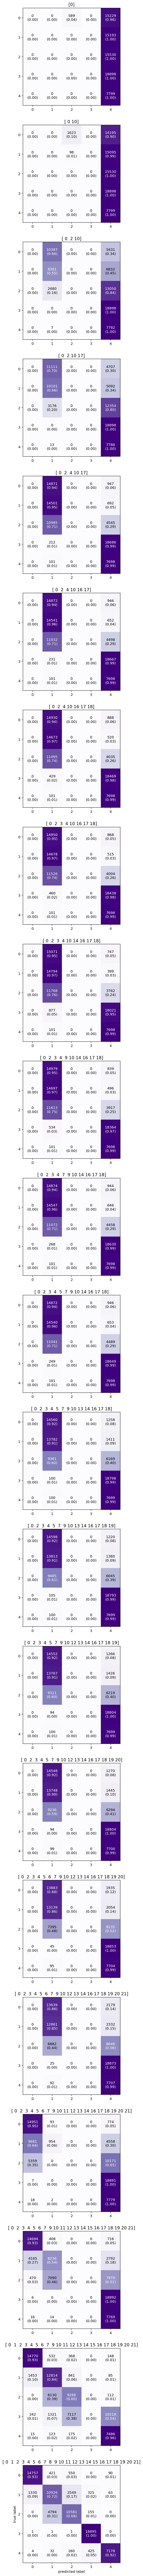

In [66]:
subsamples_cm(subsamples, sgd_logit, X_train, y_train, X_test, y_test)

#### Видим, что при добавлении 8 фичи классы 3 и 4 (нумерация с 0) стали различимы (в терминах задачи walking и running)

### Ответ: 8 фича (X8)

## (4) random forest

### params search

In [27]:
# rfc = RandomForestClassifier(n_jobs=-1, random_state=322)

pipe = Pipeline([('MinMax',  MinMaxScaler()),
                 ('RandomForest', RandomForestClassifier(n_jobs=-1, random_state=0))])

params = {'RandomForest__n_estimators' : [200],
          'RandomForest__max_features' : range(1, 5),
          'RandomForest__max_depth' : range(2, 8),
          'RandomForest__class_weight' : ['balanced', None]}

cv = GridSearchCV(pipe, params, n_jobs=-1, cv=5)

In [29]:
cv.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MinMax', MinMaxScaler()),
                                       ('RandomForest',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'RandomForest__class_weight': ['balanced', None],
                         'RandomForest__max_depth': range(2, 8),
                         'RandomForest__max_features': range(1, 5),
                         'RandomForest__n_estimators': [200]})

In [30]:
print(f'best score is {cv.best_score_} '
      f'with these params:\n{cv.best_params_}')

best score is 0.9243502304147466 with these params:
{'RandomForest__class_weight': None, 'RandomForest__max_depth': 7, 'RandomForest__max_features': 4, 'RandomForest__n_estimators': 200}


### estimation

In [31]:

best_rfc_params = {key[14:] : val for key, val in cv.best_params_.items()}

best_rfc = RandomForestClassifier(n_jobs=-1, random_state=0, **best_rfc_params)
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features=4, n_estimators=200, n_jobs=-1,
                       random_state=0)

In [32]:
train_pred = best_rfc.predict(X_train)
test_pred = best_rfc.predict(X_test)
print(f'train accuracy: {accuracy_score(y_train, train_pred):.3f}\n'
      f'test accuracy: {accuracy_score(y_test, test_pred):.3f}')

train accuracy: 0.970
test accuracy: 0.962


In [33]:
print(f'Train:\n{classification_report(y_train, train_pred)}\n\n'
      f'Test:\n{classification_report(y_test, test_pred)}')

Train:
              precision    recall  f1-score   support

           1       1.00      0.96      0.98      1757
           2       0.96      0.96      0.96      1688
           3       0.92      0.96      0.94      1726
           4       0.99      0.99      0.99      2100
           5       1.00      0.98      0.99       866

    accuracy                           0.97      8137
   macro avg       0.97      0.97      0.97      8137
weighted avg       0.97      0.97      0.97      8137


Test:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97     15818
           2       0.94      0.95      0.94     15193
           3       0.90      0.95      0.93     15530
           4       0.98      0.99      0.99     18898
           5       1.00      0.98      0.99      7799

    accuracy                           0.96     73238
   macro avg       0.97      0.96      0.96     73238
weighted avg       0.96      0.96      0.96     73238



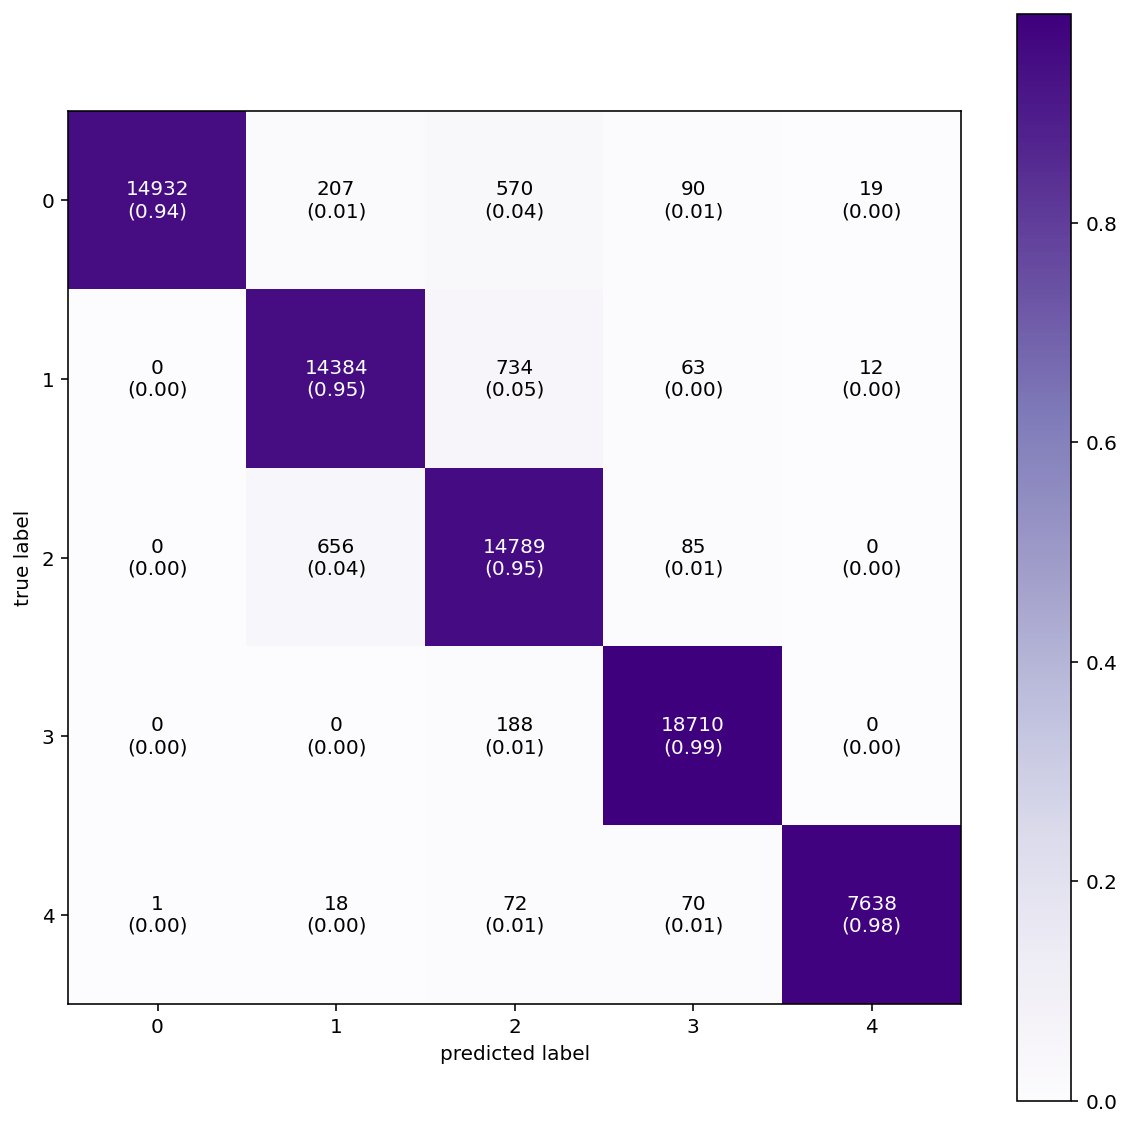

In [34]:
cm_rfc = confusion_matrix(y_target=y_test, y_predicted=test_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm_rfc,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='Purples',
                                figsize=(10, 10))

plt.show()

### which feature is most important for distinguishing walking from running

<BarContainer object of 22 artists>

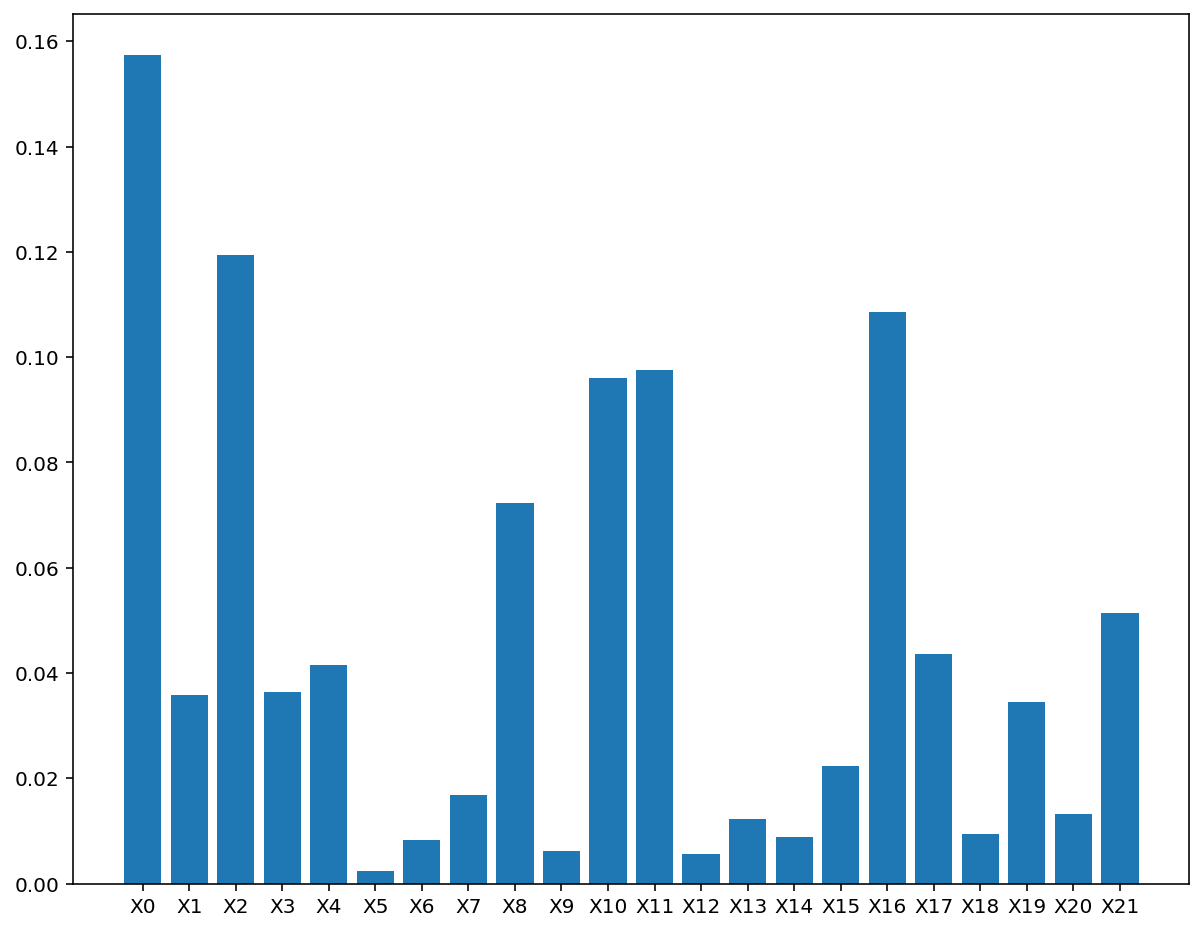

In [35]:
features = df.drop('Y', axis=1).columns

plt.figure(figsize=(10,8))
plt.bar(features, best_rfc.feature_importances_)

In [109]:
mask_train = (y_train == 5) | (y_train == 4)
mask_test = (y_test == 5) | (y_test == 4)
y_train45 = y_train[mask_train]
X_train45 = X_train[mask_train]
y_test45 = y_test[mask_test]
X_test45 = X_test[mask_test]

In [110]:
sfs1 = SFS(best_rfc, 
           k_features=5, 
           forward=False, 
           floating=False, 
           verbose=2,
           n_jobs=-1, 
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   13.0s finished

[2022-04-29 22:06:26] Features: 21/5 -- score: -0.058498218016467984[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   11.8s finished

[2022-04-29 22:06:38] Features: 20/5 -- score: -0.05333661054442669[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.6s finished

[2022-04-29 22:06:50] Features: 19/5 -- score: -0.057023473024456185[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   11.3s finished

[2022-04-29 22:07:01] Features: 18/5 -- sco

In [111]:
features = [x for i, x in enumerate(list(df.drop('Y', axis=1).columns)) if i in sfs1.k_feature_idx_]
print(features)

['X0', 'X1', 'X8', 'X10', 'X17']


In [123]:
sfs1 = SFS(best_rfc, 
           k_features=5, 
           forward=False, 
           floating=False, 
           verbose=2,
           n_jobs=-1, 
           scoring='neg_mean_squared_error',
           cv=0)

sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   13.3s finished

[2022-04-29 22:27:05] Features: 21/5 -- score: -0.058498218016467984[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   12.0s finished

[2022-04-29 22:27:17] Features: 20/5 -- score: -0.05333661054442669[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.4s finished

[2022-04-29 22:27:29] Features: 19/5 -- score: -0.057023473024456185[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   10.7s finished

[2022-04-29 22:27:40] Features: 18/5 -- sco

In [124]:
sfs1.subsets_

{22: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21),
  'cv_scores': array([-0.06562615]),
  'avg_score': -0.06562615214452501,
  'feature_names': ('0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '19',
   '20',
   '21')},
 21: {'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   20,
   21),
  'cv_scores': array([-0.05849822]),
  'avg_score': -0.058498218016467984,
  'feature_names': ('0',
   '1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '20',
   '21')},
 20: {'feature_idx': (0,
   1,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   

In [125]:
subsamples = [np.array(val['feature_names']).astype(int) for val in sfs1.subsets_.values()]
subsamples

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 20, 21]),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 20, 21]),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 20]),
 array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        20]),
 array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 20]),
 array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 20]),
 array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17]),
 array([ 0,  1,  3,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17]),
 array([ 0,  1,  5,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17]),
 array([ 0,  1,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17]),
 array([ 0,  1,  8,  9, 10, 12, 13, 14, 15, 16, 17]),
 array([ 0,  1,  8,  9, 10, 12, 14, 15, 16, 17])

In [102]:
# def custom_features_model(model, features):
#     newmodel = clone(model)
#     newmodel.fit(X_train, y_train)
#     save_coefs = newmodel.feature_importances_[:, features]
#     coef_new = np.zeros(model.feature_importances_.shape)
#     coef_new[:, features] = save_coefs
#     newmodel.coef_ = coef_new
#     return newmodel

In [103]:
# def subsamples_cm(subsamples, model, X_train, y_train, X_test, y_test):
#     fig, ax = plt.subplots(len(subsamples), 1, figsize=(6, len(subsamples) * 6))
    
#     for i, sample in enumerate(subsamples):
#         sgd2feats = custom_features_model(best_rfc, sample)
#         y_pred = sgd2feats.predict(X_test)
#         cm = confusion_matrix(y_target=y_test, y_predicted=y_pred)
#         plot_confusion_matrix(conf_mat=cm,
#                                         show_absolute=True,
#                                         show_normed=True,
#                                         cmap='Purples',
#                                         axis=ax[i])
#         ax[i].set_title(str(sample));

In [105]:
# subsamples_cm(subsamples, best_rfc, X_train, y_train, X_test, y_test)

### Очевидный вывод, что наиболее важная фича X0 - это видно по гистограмме, но важная не значит отличительная

### Если проследить по массивам добавления фичей, то, конечно, удивительно, но отличительной в рассматриваемом случае будет X19

### Чтобы на 100 процентов быть уверенным в ответе, в идеале, конечно, снова построить confusion matrix и отследить момент различия по ним.

## (5) neural network

In [36]:
mlp = MLPClassifier(random_state=322,        #not to get different model each time
                    hidden_layer_sizes=(200),    #number of layers and number of neurons
                    activation='relu',
                    solver='sgd',
                    alpha=0.0001,                           # L2 regularization
                    learning_rate_init=0.001,
                    max_iter=150,
                    early_stopping=True,           #automatically set aside part of train to validate
                    tol=0.005, 
                    verbose=2           # if error decrease is less than tol, stop 
                   )

In [37]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.60630430
Validation score: 0.367322
Iteration 2, loss = 1.55765938
Validation score: 0.345209
Iteration 3, loss = 1.53830659
Validation score: 0.337838
Iteration 4, loss = 1.52651246
Validation score: 0.345209
Iteration 5, loss = 1.51603427
Validation score: 0.386978
Iteration 6, loss = 1.50615483
Validation score: 0.402948
Iteration 7, loss = 1.49637428
Validation score: 0.402948
Iteration 8, loss = 1.48662446
Validation score: 0.425061
Iteration 9, loss = 1.47691343
Validation score: 0.436118
Iteration 10, loss = 1.46706742
Validation score: 0.439803
Iteration 11, loss = 1.45705101
Validation score: 0.442260
Iteration 12, loss = 1.44684067
Validation score: 0.442260
Iteration 13, loss = 1.43642200
Validation score: 0.445946
Iteration 14, loss = 1.42591812
Validation score: 0.445946
Iteration 15, loss = 1.41536384
Validation score: 0.445946
Iteration 16, loss = 1.40462870
Validation score: 0.463145
Iteration 17, loss = 1.39375740
Validation score: 0.471744
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=200, max_iter=150,
              random_state=322, solver='sgd', tol=0.005, verbose=2)

In [38]:
train_pred = mlp.predict(X_train)
test_pred = mlp.predict(X_test)
print(f'train accuracy: {accuracy_score(y_train, train_pred):.3f}\n'
      f'test accuracy: {accuracy_score(y_test, test_pred):.3f}')

train accuracy: 0.804
test accuracy: 0.803


In [39]:
print(f'Train:\n{classification_report(y_train, train_pred)}\n\n'
      f'Test:\n{classification_report(y_test, test_pred)}')

Train:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93      1757
           2       0.63      0.61      0.62      1688
           3       0.67      0.66      0.67      1726
           4       0.89      1.00      0.94      2100
           5       0.98      0.71      0.83       866

    accuracy                           0.80      8137
   macro avg       0.82      0.79      0.80      8137
weighted avg       0.80      0.80      0.80      8137


Test:
              precision    recall  f1-score   support

           1       0.91      0.94      0.92     15818
           2       0.63      0.60      0.62     15193
           3       0.68      0.67      0.67     15530
           4       0.89      1.00      0.94     18898
           5       0.99      0.70      0.82      7799

    accuracy                           0.80     73238
   macro avg       0.82      0.78      0.79     73238
weighted avg       0.80      0.80      0.80     73238



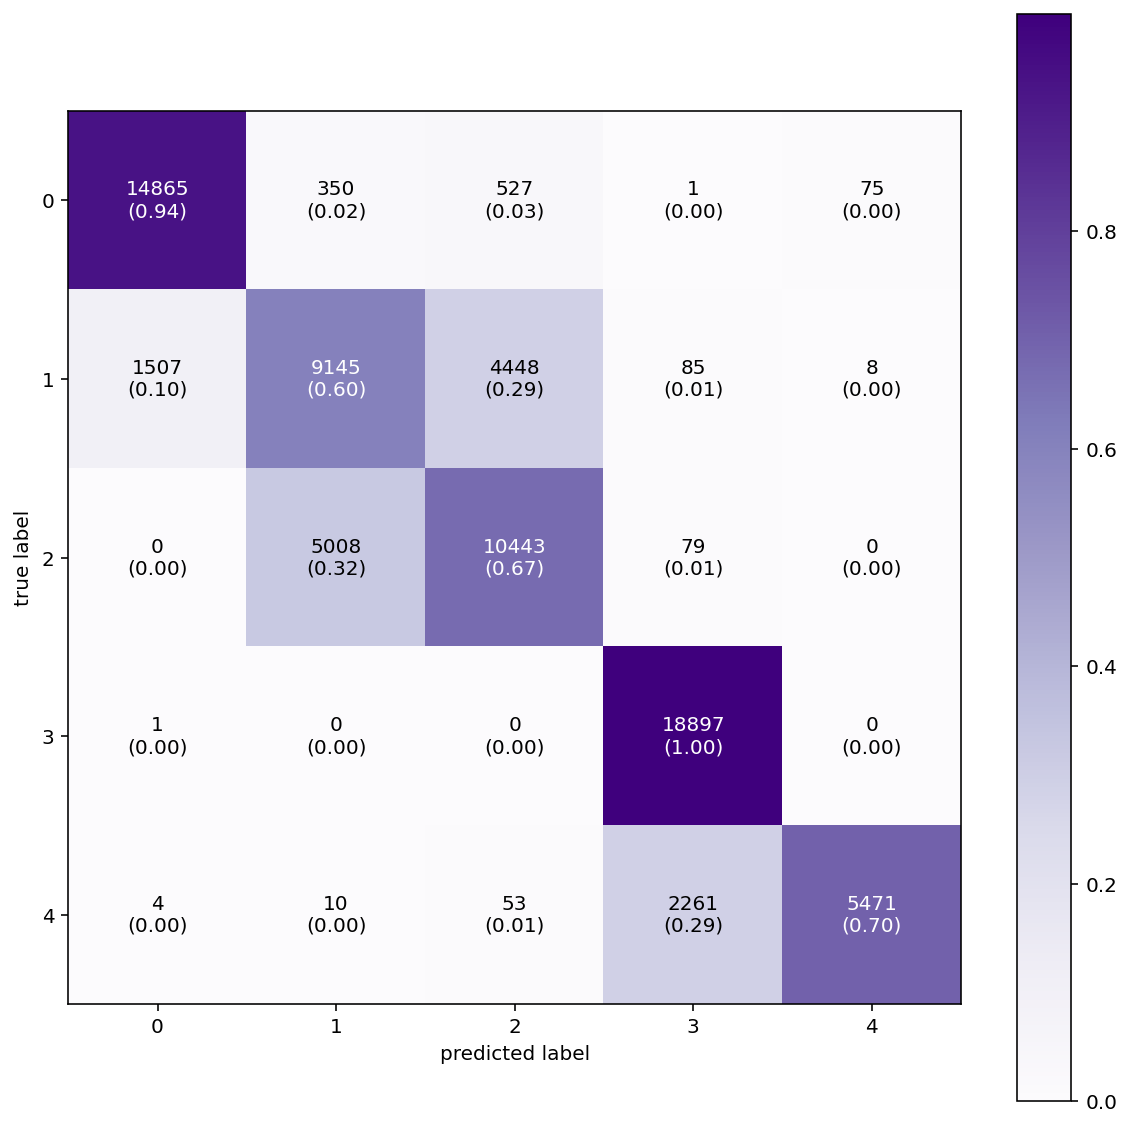

In [40]:
cm_nn = confusion_matrix(y_target=y_test, y_predicted=test_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm_nn,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='Purples',
                                figsize=(10, 10))

plt.show()

In [73]:
def n_nodes_nn_process(n_nodes, act_f='relu'):
    mlp = MLPClassifier(random_state=322,        #not to get different model each time
                    hidden_layer_sizes=(n_nodes),    #number of layers and number of neurons
                    activation=act_f,
                    solver='sgd',
                    alpha=0.0001,                           # L2 regularization
                    learning_rate_init=0.001,
                    max_iter=150,
                    early_stopping=True,           #automatically set aside part of train to validate
                    tol=0.005, 
                   )
    mlp.fit(X_train, y_train)
    
    
    train_pred = mlp.predict(X_train)
    test_pred = mlp.predict(X_test)
    print(f'train accuracy: {accuracy_score(y_train, train_pred):.3f}\n'
          f'test accuracy: {accuracy_score(y_test, test_pred):.3f}')
    
    
    print(f'Train:\n{classification_report(y_train, train_pred)}\n\n'
      f'Test:\n{classification_report(y_test, test_pred)}')
    
    
    cm_nn = confusion_matrix(y_target=y_test, y_predicted=test_pred)
    
    fig, ax = plot_confusion_matrix(conf_mat=cm_nn,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    cmap='Purples',
                                    figsize=(10, 10))

    plt.show();

train accuracy: 0.735
test accuracy: 0.735
Train:
              precision    recall  f1-score   support

           1       0.76      0.96      0.85      1757
           2       0.53      0.35      0.42      1688
           3       0.62      0.58      0.60      1726
           4       0.80      1.00      0.89      2100
           5       1.00      0.71      0.83       866

    accuracy                           0.73      8137
   macro avg       0.74      0.72      0.72      8137
weighted avg       0.72      0.73      0.72      8137


Test:
              precision    recall  f1-score   support

           1       0.77      0.95      0.85     15818
           2       0.54      0.36      0.43     15193
           3       0.62      0.58      0.60     15530
           4       0.80      1.00      0.89     18898
           5       1.00      0.70      0.82      7799

    accuracy                           0.73     73238
   macro avg       0.75      0.72      0.72     73238
weighted avg       0

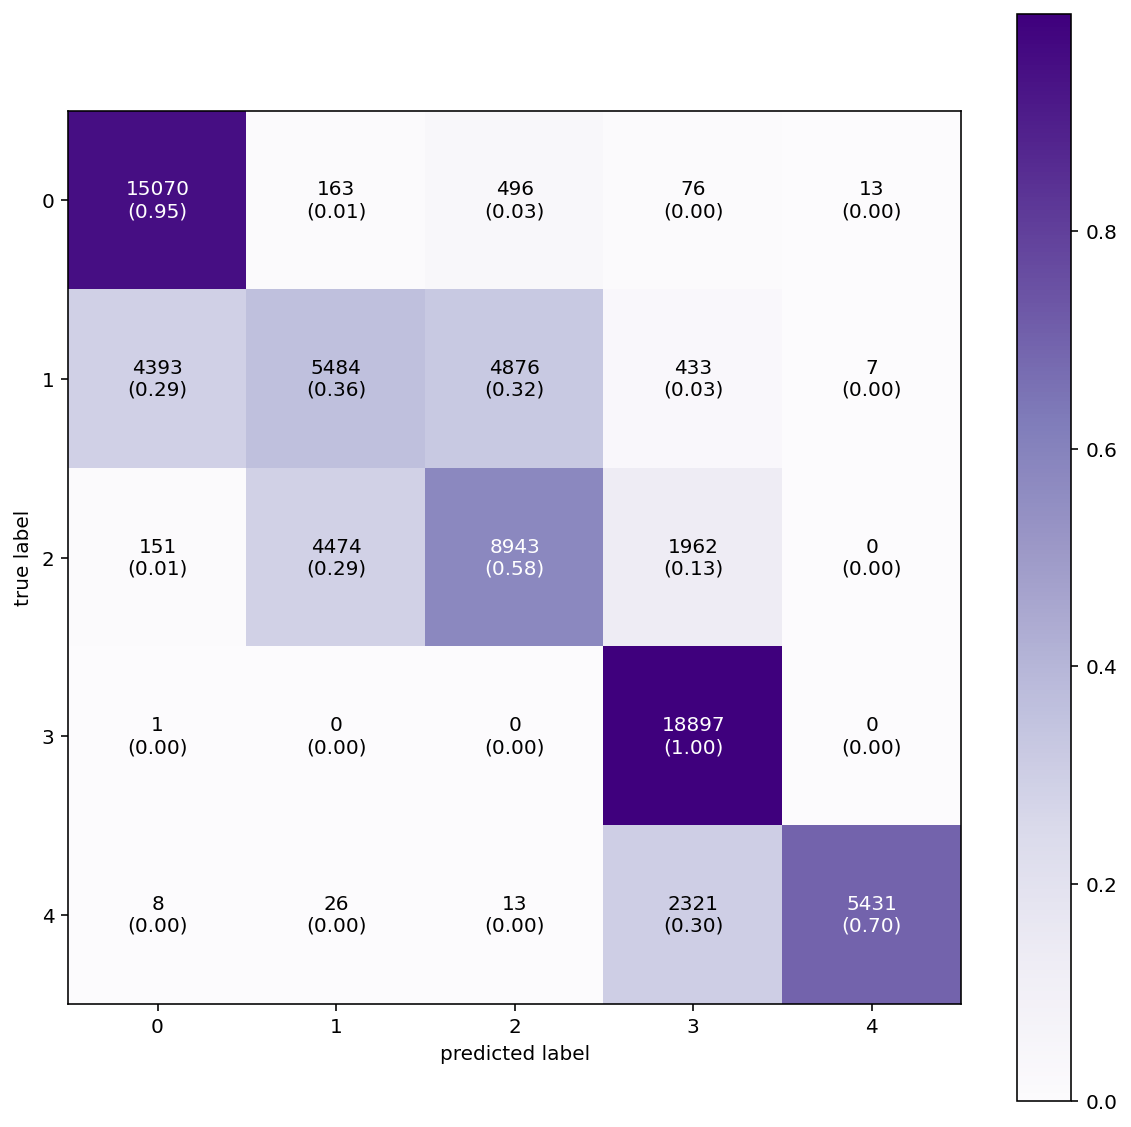

In [74]:
n_nodes_nn_process(400)

train accuracy: 0.829
test accuracy: 0.823
Train:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93      1757
           2       0.70      0.64      0.67      1688
           3       0.71      0.75      0.73      1726
           4       0.89      1.00      0.94      2100
           5       0.98      0.72      0.83       866

    accuracy                           0.83      8137
   macro avg       0.84      0.81      0.82      8137
weighted avg       0.83      0.83      0.83      8137


Test:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93     15818
           2       0.68      0.64      0.66     15193
           3       0.70      0.73      0.72     15530
           4       0.89      1.00      0.94     18898
           5       0.98      0.71      0.83      7799

    accuracy                           0.82     73238
   macro avg       0.84      0.80      0.81     73238
weighted avg       0

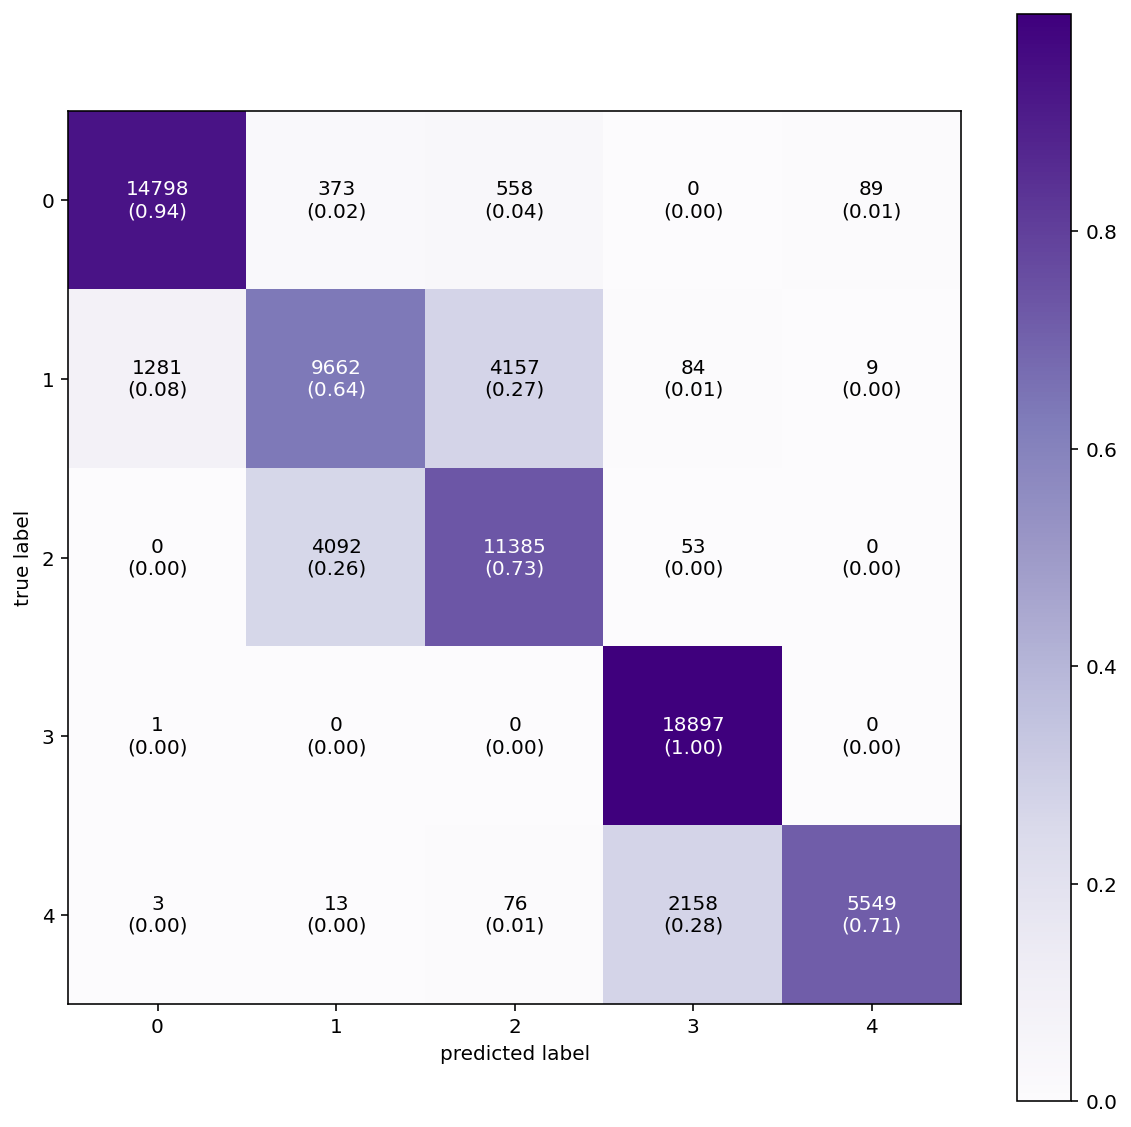

In [75]:
n_nodes_nn_process(400, 'tanh')

train accuracy: 0.716
test accuracy: 0.717
Train:
              precision    recall  f1-score   support

           1       0.71      0.96      0.81      1757
           2       0.56      0.39      0.46      1688
           3       0.72      0.48      0.58      1726
           4       0.74      1.00      0.85      2100
           5       1.00      0.63      0.77       866

    accuracy                           0.72      8137
   macro avg       0.74      0.69      0.69      8137
weighted avg       0.72      0.72      0.70      8137


Test:
              precision    recall  f1-score   support

           1       0.71      0.96      0.81     15818
           2       0.57      0.41      0.48     15193
           3       0.74      0.49      0.59     15530
           4       0.73      1.00      0.84     18898
           5       1.00      0.60      0.75      7799

    accuracy                           0.72     73238
   macro avg       0.75      0.69      0.69     73238
weighted avg       0

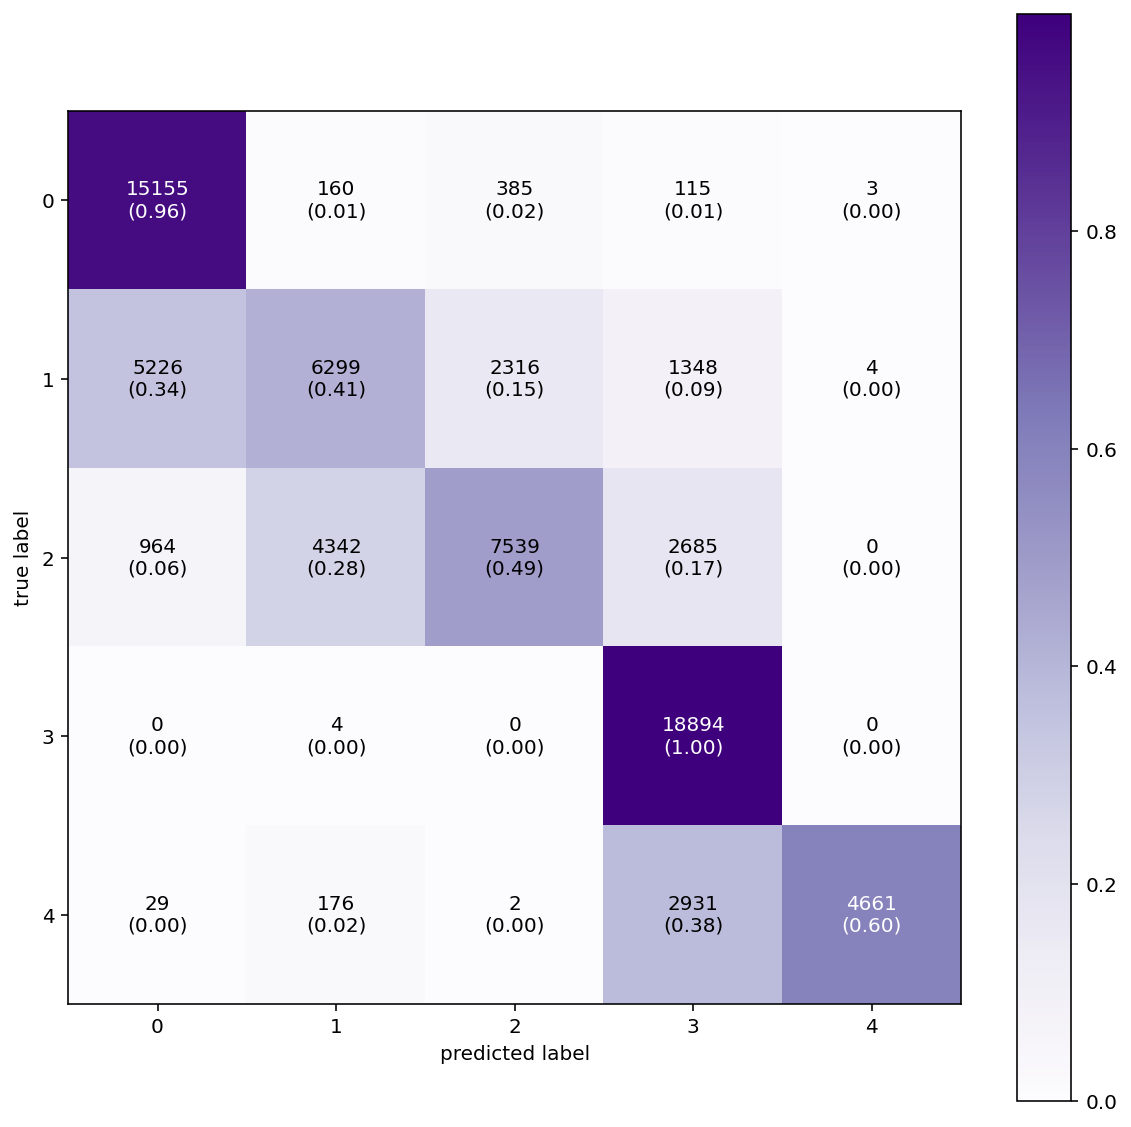

In [76]:
n_nodes_nn_process(64)

train accuracy: 0.296
test accuracy: 0.293
Train:
              precision    recall  f1-score   support

           1       0.41      0.40      0.40      1757
           2       0.01      0.00      0.00      1688
           3       0.01      0.00      0.00      1726
           4       0.29      0.81      0.43      2100
           5       0.00      0.00      0.00       866

    accuracy                           0.30      8137
   macro avg       0.14      0.24      0.17      8137
weighted avg       0.17      0.30      0.20      8137


Test:
              precision    recall  f1-score   support

           1       0.42      0.40      0.41     15818
           2       0.02      0.00      0.00     15193
           3       0.02      0.00      0.01     15530
           4       0.28      0.80      0.42     18898
           5       0.00      0.00      0.00      7799

    accuracy                           0.29     73238
   macro avg       0.15      0.24      0.17     73238
weighted avg       0

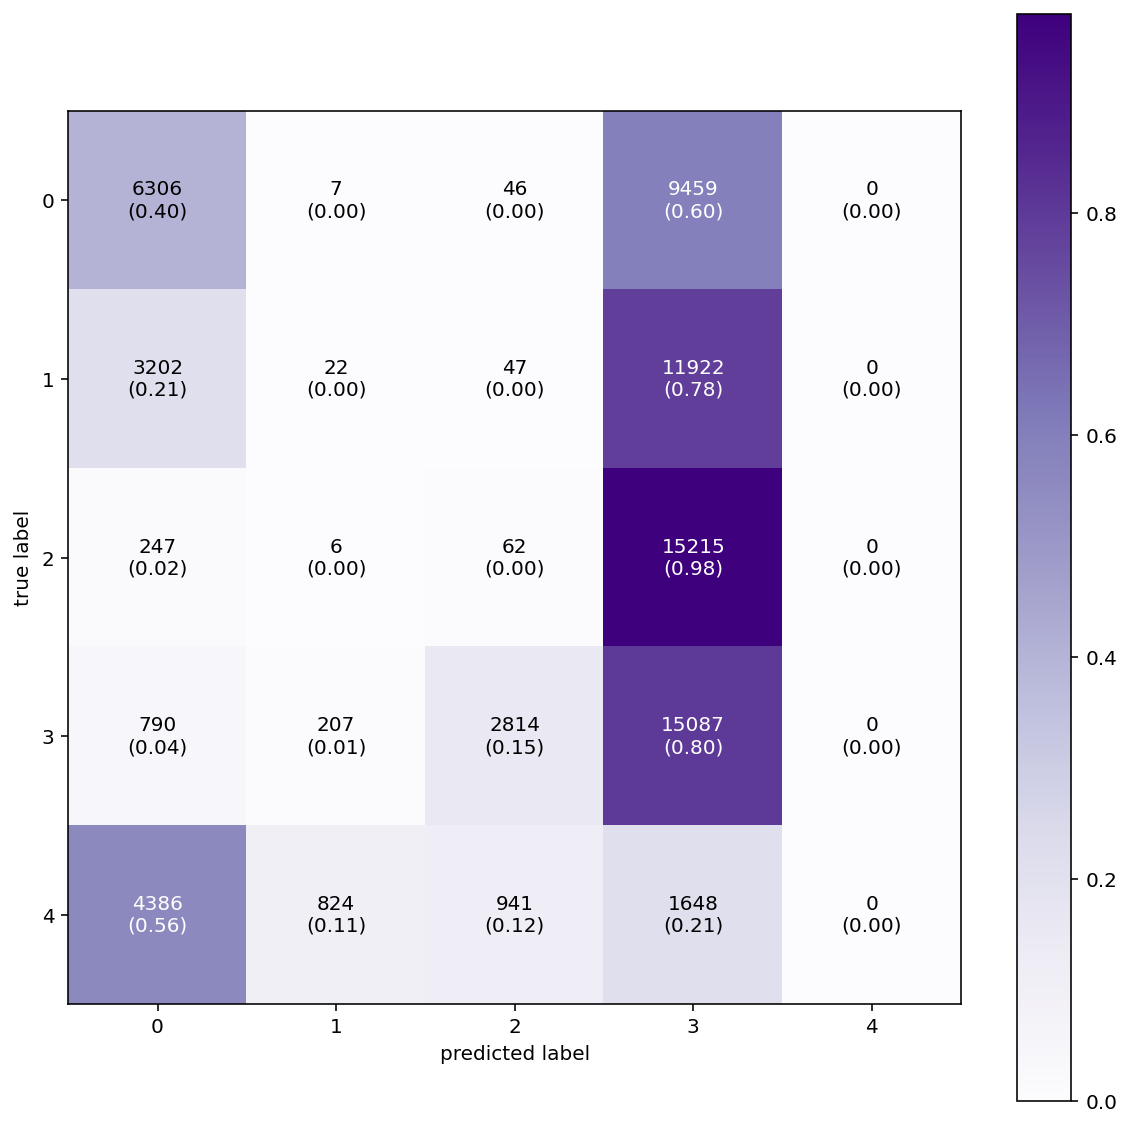

In [84]:
n_nodes_nn_process(10)

train accuracy: 0.701
test accuracy: 0.703
Train:
              precision    recall  f1-score   support

           1       0.75      0.96      0.84      1757
           2       0.43      0.27      0.33      1688
           3       0.54      0.50      0.52      1726
           4       0.79      1.00      0.88      2100
           5       1.00      0.71      0.83       866

    accuracy                           0.70      8137
   macro avg       0.70      0.69      0.68      8137
weighted avg       0.68      0.70      0.68      8137


Test:
              precision    recall  f1-score   support

           1       0.76      0.95      0.84     15818
           2       0.44      0.28      0.34     15193
           3       0.55      0.50      0.53     15530
           4       0.79      1.00      0.88     18898
           5       1.00      0.69      0.82      7799

    accuracy                           0.70     73238
   macro avg       0.71      0.69      0.68     73238
weighted avg       0

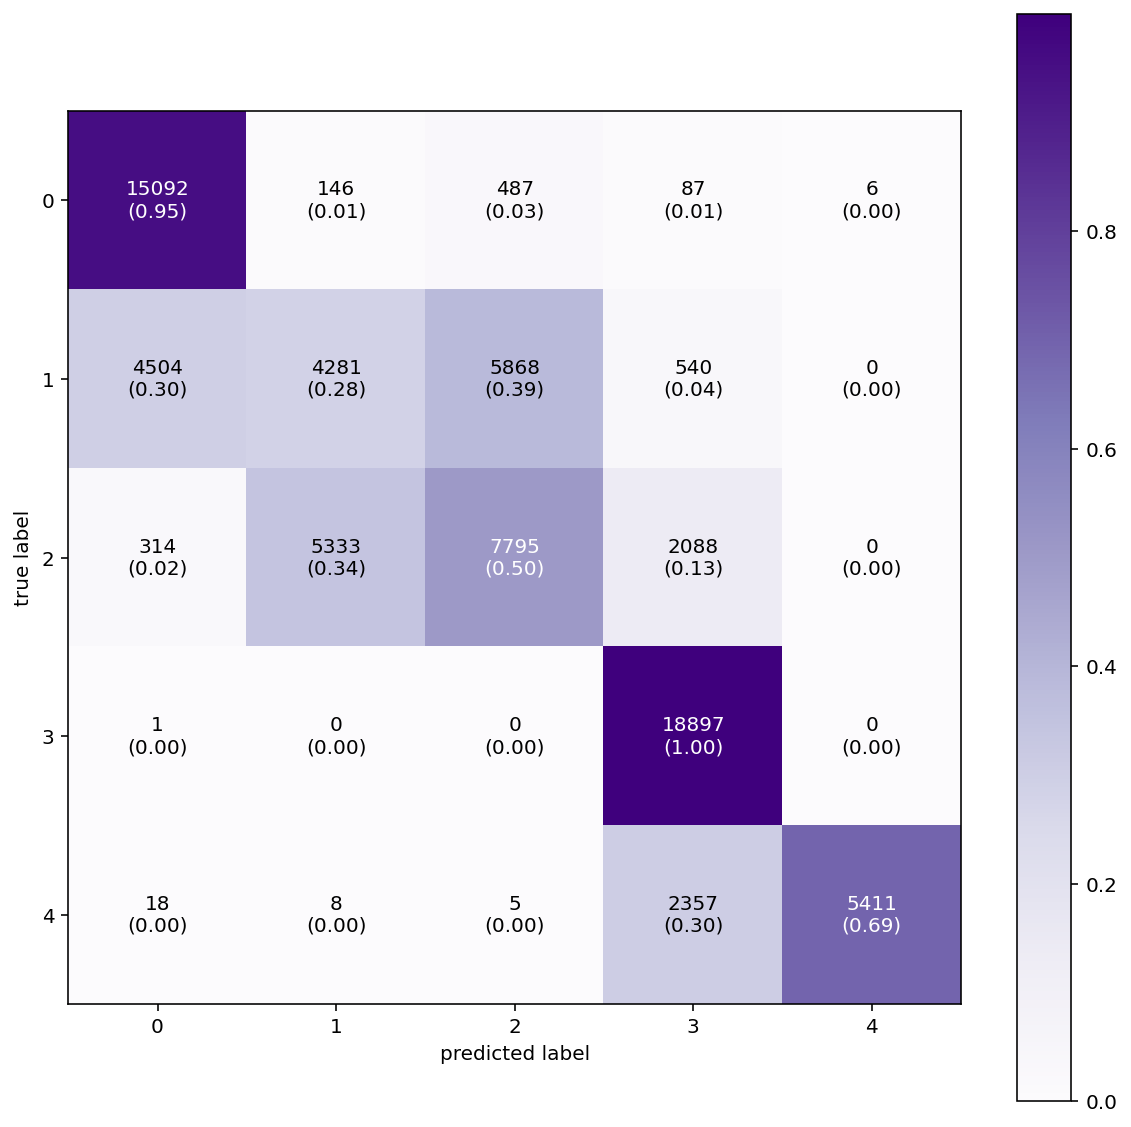

In [85]:
n_nodes_nn_process(750)

<b>TODO:</b> custom nn without presets

## (6) gradient boosting (catboost)

In [105]:
cb = CatBoostClassifier(loss_function='MultiClass', random_state=322, verbose=100)
cb.fit(X_train, y_train)

Learning rate set to 0.088056
0:	learn: 1.3529688	total: 184ms	remaining: 3m 4s
100:	learn: 0.0603389	total: 1.75s	remaining: 15.6s
200:	learn: 0.0268664	total: 3.09s	remaining: 12.3s
300:	learn: 0.0159792	total: 4.51s	remaining: 10.5s
400:	learn: 0.0106755	total: 5.91s	remaining: 8.83s
500:	learn: 0.0078441	total: 7.31s	remaining: 7.28s
600:	learn: 0.0058923	total: 8.68s	remaining: 5.76s
700:	learn: 0.0048087	total: 10.1s	remaining: 4.29s
800:	learn: 0.0040053	total: 11.4s	remaining: 2.82s
900:	learn: 0.0034130	total: 12.7s	remaining: 1.39s
999:	learn: 0.0029259	total: 14s	remaining: 0us


In [106]:
train_pred = cb.predict(X_train).reshape(train_pred.shape[0])
test_pred = cb.predict(X_test).reshape(test_pred.shape[0])
print(f'train accuracy: {accuracy_score(y_train, train_pred):.3f}\n'
      f'test accuracy: {accuracy_score(y_test, test_pred):.3f}')

train accuracy: 1.000
test accuracy: 0.996


In [107]:
print(f'Train:\n{classification_report(y_train, train_pred)}\n\n'
      f'Test:\n{classification_report(y_test, test_pred)}')

Train:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1757
           2       1.00      1.00      1.00      1688
           3       1.00      1.00      1.00      1726
           4       1.00      1.00      1.00      2100
           5       1.00      1.00      1.00       866

    accuracy                           1.00      8137
   macro avg       1.00      1.00      1.00      8137
weighted avg       1.00      1.00      1.00      8137


Test:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00     15818
           2       1.00      0.99      0.99     15193
           3       0.99      1.00      0.99     15530
           4       1.00      1.00      1.00     18898
           5       1.00      1.00      1.00      7799

    accuracy                           1.00     73238
   macro avg       1.00      1.00      1.00     73238
weighted avg       1.00      1.00      1.00     73238



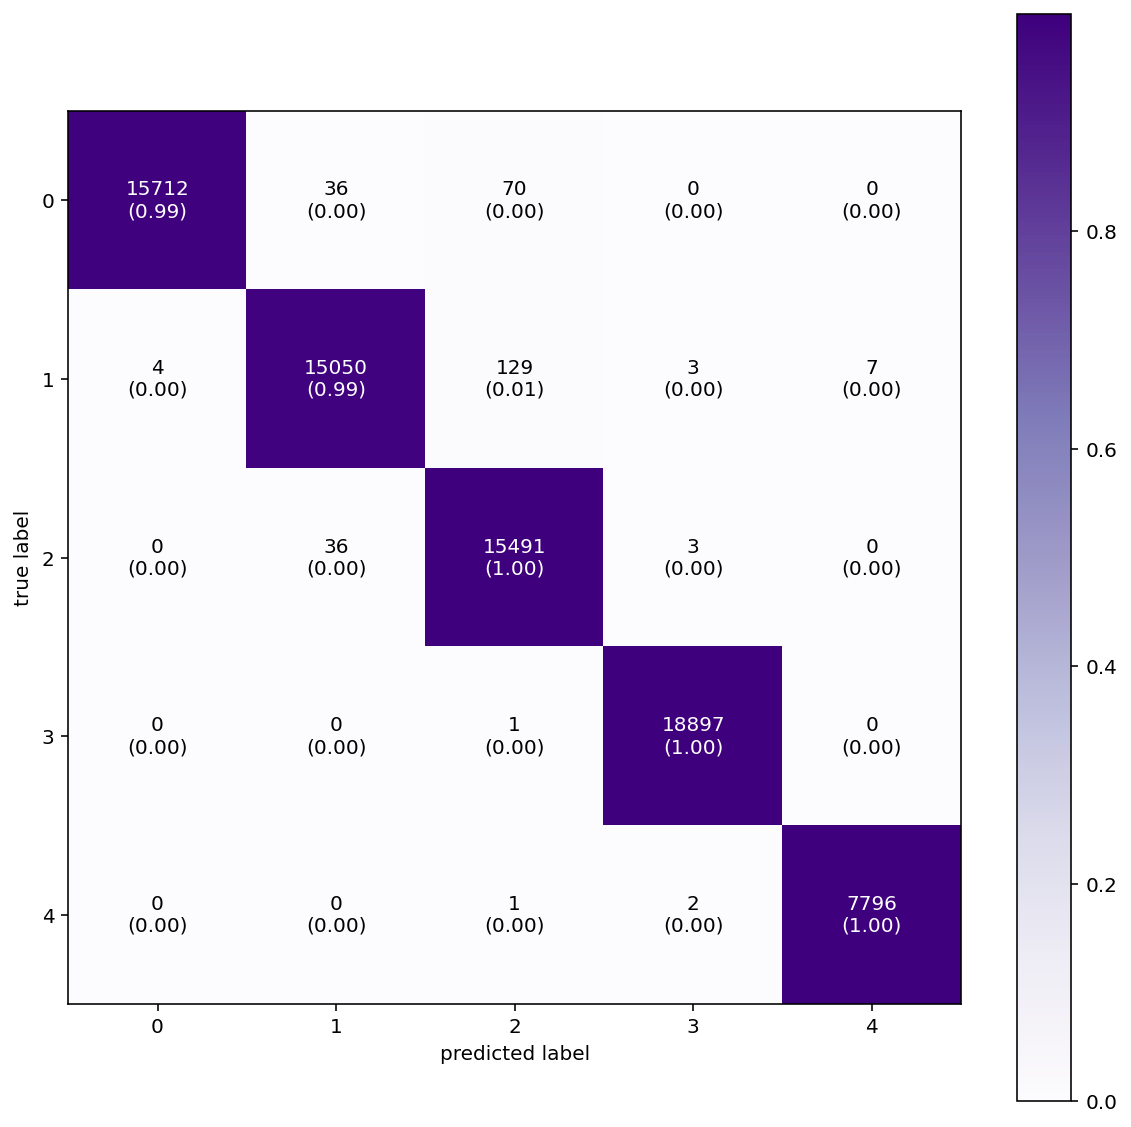

In [108]:
cm_cb = confusion_matrix(y_target=y_test, y_predicted=test_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm_cb,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                cmap='Purples',
                                figsize=(10, 10))

plt.show()

## (7) 

I'd prefer any gradient boosting model, catboost in this case. It is usually better than any other models mathematically. It fits well on less data (50% of dataset in this task). Catboost specifically is a well designed library and requires no skill to use with artificial datasets / datasets for education purposes :)

To be fair, neural networks do well too. However, in this task we were only allowed to use only one layer so definitely the state of art model in classical machine learning will show the best quallity